In [1]:
import wandb
import numpy as np
import sys
import torch
import torch.utils.data as Data
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import pytorch_lightning as pl
import torch.nn as nn
import glob
import xarray as xr
import matplotlib.pyplot as plt
from xhistogram.xarray import histogram as xhist


BASE = '/scratch/ab10313/pleiades/'
PATH_NN= BASE+'NN_data_1_4/'


import submeso_ml.systems.regression_system as regression_system
import submeso_ml.models.fcnn as fcnn
import submeso_ml.data.dataset as dataset

# Define X,Y pairs (state, subgrid fluxes) for local network.local_torch_dataset = Data.TensorDataset(
BATCH_SIZE = 64  # Number of sample in each batch


submeso_dataset=dataset.SubmesoDataset(['grad_B','FCOR', 'HML', 'TAU',
              'Q', 'HBL', 'div', 'vort', 'strain'],res='1_4')


train_loader=DataLoader(
    submeso_dataset,
    num_workers=10,
    batch_size=64,
    sampler=SubsetRandomSampler(submeso_dataset.train_ind))

test_loader=DataLoader(
    submeso_dataset,
    num_workers=10,
    batch_size=len(submeso_dataset.test_ind),
    sampler=submeso_dataset.test_ind)

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/ab10313/pleiades/NN_data_1_4/grad_B.npy'

In [2]:
model = torch.load('/scratch/ab10313/pleiades/trained_models/fcnn_k5_l7_res_1_4.pt')

In [3]:
# use GPUs if available
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')

CUDA Not Available


In [4]:
for x_data, y_data in test_loader:
    b_x = x_data
    b_y = y_data
    prediction = model(b_x.to(device)) 

In [5]:
PATH_LIST_full = glob.glob(BASE+'*/preprocessed_data/')

In [7]:
label_list = ['Arabian Sea','New Zealand', 'Agulhas Current', 'Kuroshio Extension', 'North Pacific', 'Equatorial Atlantic',
              'Gulf Stream', 'South Atlantic', 'Malvinas Current', 'South Pacific','California Current', 'Indian Ocean', ]

In [8]:

#locations
location_index = np.zeros(846*12)
location_month_index= np.zeros(846*12)


for i in range(12):
    for j in range(846):
        location_index[i*846+j] = i
        location_month_index[i*846+j] = np.floor(j/60)


# prediction timeseries

In [9]:
drF = np.load(PATH_NN+'drF.npy')
WB_FK = np.load(PATH_NN+'WB_FK08_param.npy')
WB_sg_full= np.load(PATH_NN+'WB_sg.npy')
WB_sg_mean = np.load(PATH_NN+'WB_sg_mean.npy')
WB_sg_std = np.load(PATH_NN+'WB_sg_std.npy')


In [10]:
# renormalize using mean and std 
# SORT test_ind for timeseries
test_ind = submeso_dataset.test_ind


mean_tile = np.tile(WB_sg_mean,(2030,1,40,40))
std_tile = np.tile(WB_sg_std,(2030,1,40,40))

# cell size 
drF_test = drF[test_ind] 
drF_test_loc = np.empty((12,2030,40,40))
drF_test_loc[:] = np.nan

WB_cnn = np.squeeze((model(b_x.to(device)).detach().cpu().numpy()*std_tile + mean_tile))
WB_sg = np.squeeze(xr.DataArray((b_y.detach().cpu().numpy()*std_tile + mean_tile)))

WB_cnn_loc = np.empty((12,2030,40,40))
WB_cnn_loc[:] = np.nan
WB_cnn_loc_mean = np.empty((12,2030))

WB_sg_loc = np.empty((12,2030,40,40))
WB_sg_loc[:] = np.nan
WB_sg_loc_mean = np.empty((12,2030))

WB_FK_test = WB_FK[test_ind] 
WB_FK_param = 0.07*WB_FK[test_ind]

WB_param_loc = np.empty((12,2030,40,40))
WB_param_loc[:] = np.nan
WB_param_loc_mean = np.empty((12,2030))
WB_param_loc_mean[:] = np.nan

location_month_index_test = location_month_index[test_ind]
location_month_index_loc = np.empty((12,2030))
location_month_index_loc[:] = np.nan

for i_loc in range(12):
    drF_test_loc[i_loc,location_index[test_ind]==i_loc,:,:] = drF_test[location_index[test_ind]==i_loc]
    
    WB_param_loc[i_loc,location_index[test_ind]==i_loc,:,:] = 0.07*WB_FK_test[location_index[test_ind]==i_loc]
    WB_param_loc_mean[i_loc] = (np.squeeze(np.apply_over_axes(np.sum, WB_param_loc[i_loc]*WB_param_loc[i_loc]*drF_test_loc[i_loc], [1,2])) / np.nansum(drF_test_loc[i_loc]))**0.5
    
    WB_cnn_loc[i_loc,location_index[test_ind]==i_loc,:,:] = WB_cnn[location_index[test_ind]==i_loc]
    WB_cnn_loc_mean[i_loc] = (np.squeeze(np.apply_over_axes(np.sum, WB_cnn_loc[i_loc]*WB_cnn_loc[i_loc]*drF_test_loc[i_loc], [1,2])) / np.nansum(drF_test_loc[i_loc]))**0.5  #np.nanmean(np.nanmean(WB_cnn_loc[i_loc],1),1)
    
    WB_sg_loc[i_loc,location_index[test_ind]==i_loc,:,:] = WB_sg[location_index[test_ind]==i_loc]
    WB_sg_loc_mean[i_loc] = (np.squeeze(np.apply_over_axes(np.sum, WB_sg_loc[i_loc]*WB_sg_loc[i_loc]*drF_test_loc[i_loc], [1,2]))/ np.nansum(drF_test_loc[i_loc]))**0.5 #np.nanmean(np.nanmean(WB_sg_loc[i_loc],1),1)

    location_month_index_loc[i_loc,location_index[test_ind]==i_loc] = location_month_index_test[location_index[test_ind]==i_loc]


5.0


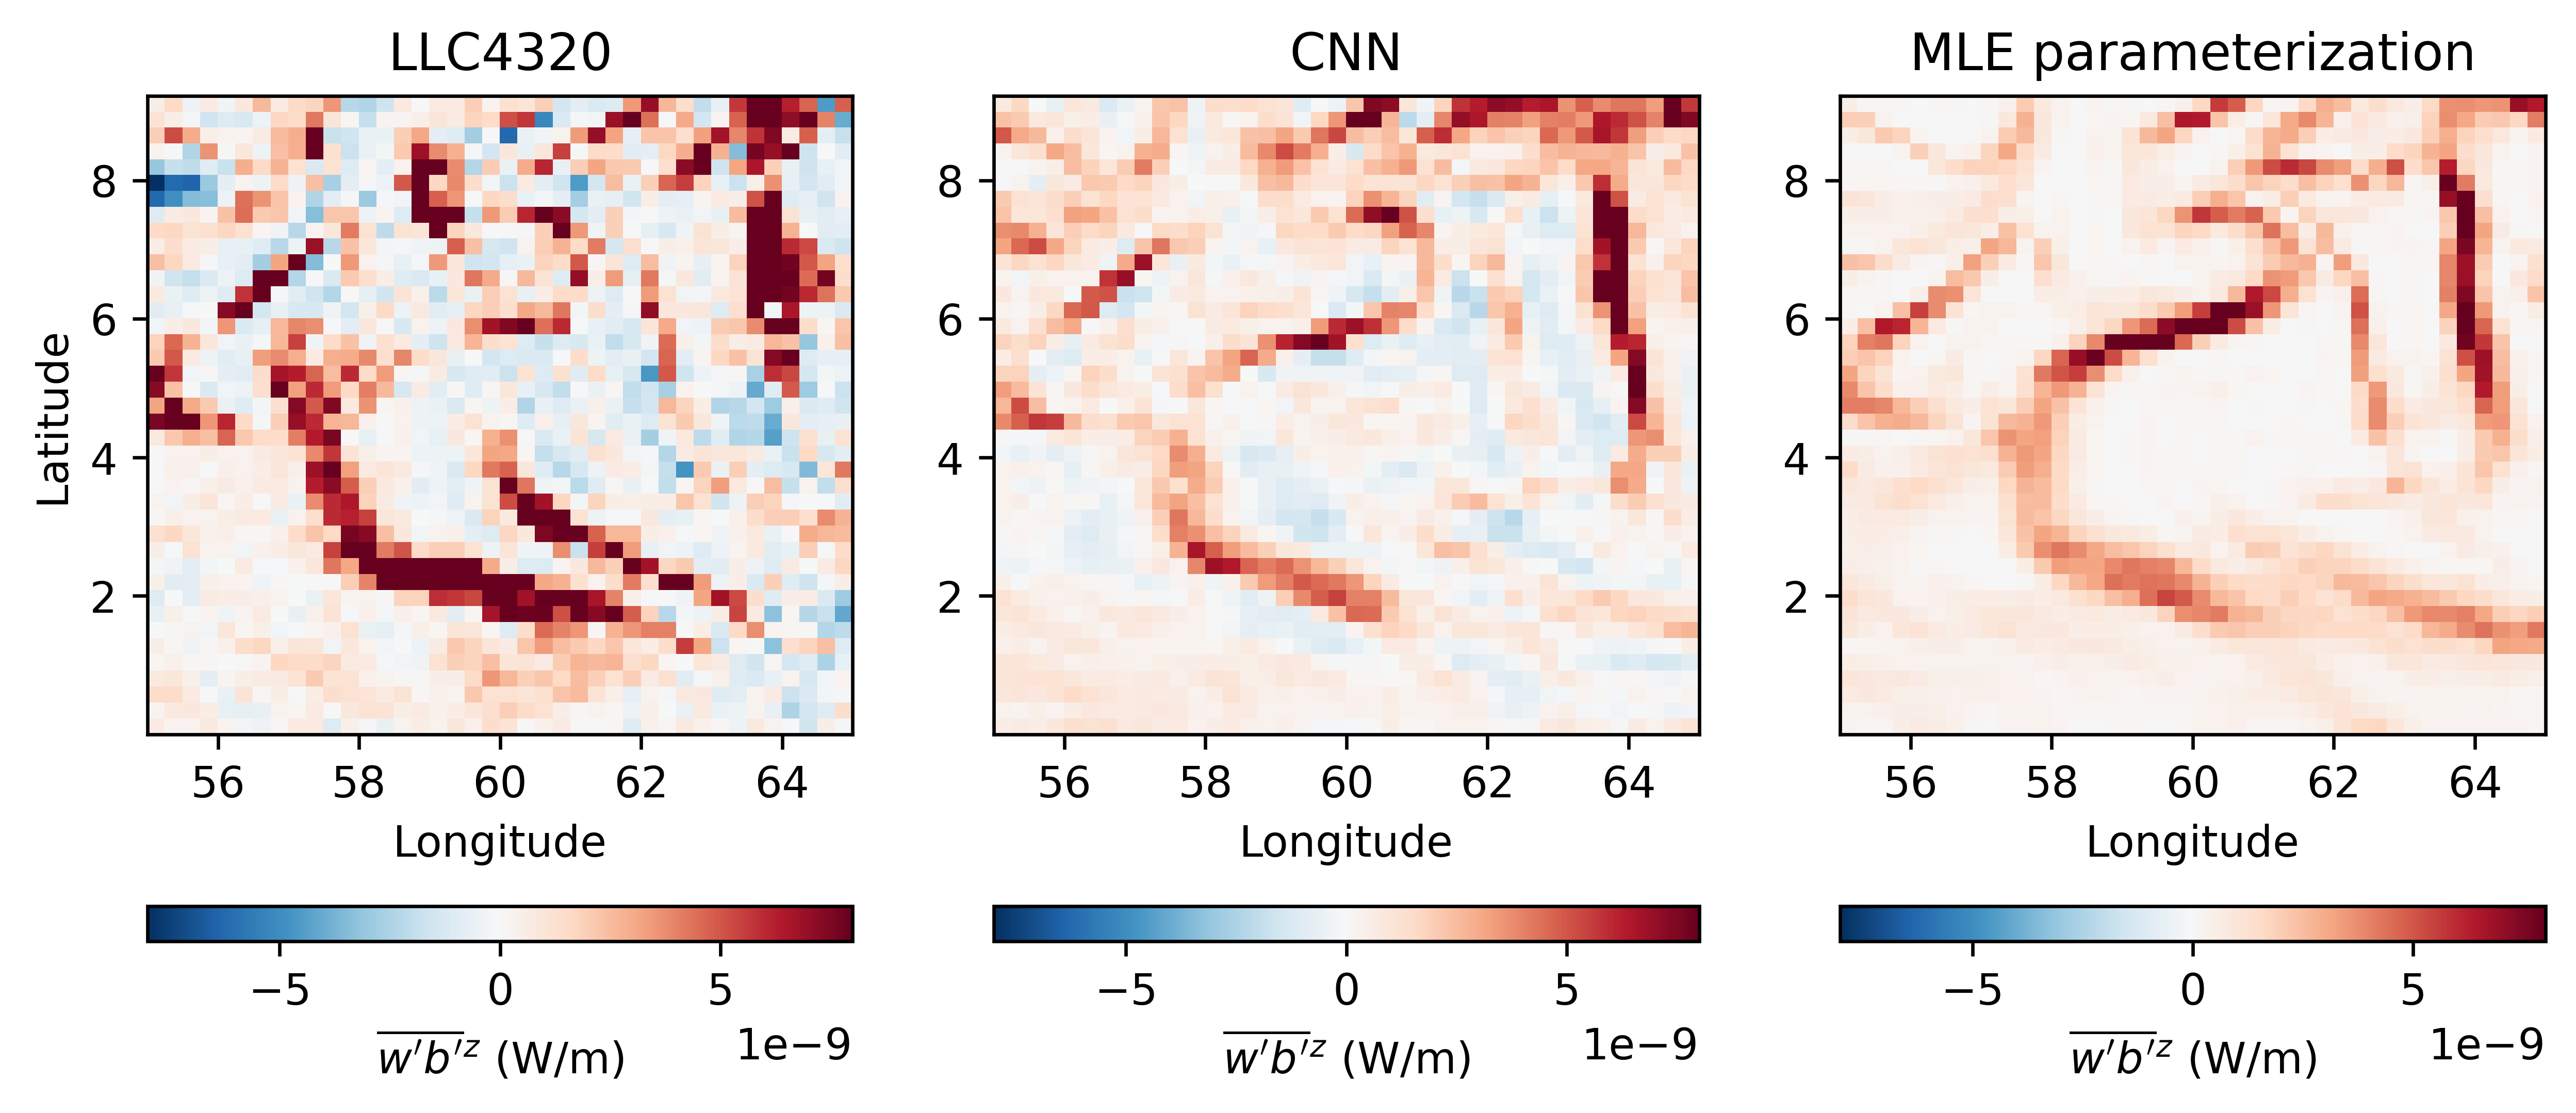

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(10,4),dpi=600)
#fig.tight_layout(pad=5.0)

i_loc=0
it = 38

clim = 8e-9

lat_plot = xr.open_dataarray(PATH_LIST_full[i_loc]+'lat.nc')
lon_plot = xr.open_dataarray(PATH_LIST_full[i_loc]+'lon.nc')

#grid scale 

grid_factor = 4
lat_1_12 = lat_plot.coarsen(j=grid_factor, boundary="trim").mean()
lon_1_12 = lon_plot.coarsen(i=grid_factor, boundary="trim").mean()

grid_factor = 6
lat_1_8 = lat_plot.coarsen(j=grid_factor, boundary="trim").mean()
lon_1_8 = lon_plot.coarsen(i=grid_factor, boundary="trim").mean()

grid_factor = 12
lat_1_4 = lat_plot.coarsen(j=grid_factor, boundary="trim").mean()
lon_1_4 = lon_plot.coarsen(i=grid_factor, boundary="trim").mean()

grid_factor = 24
lat_1_2 = lat_plot.coarsen(j=grid_factor, boundary="trim").mean()
lon_1_2 = lon_plot.coarsen(i=grid_factor, boundary="trim").mean()

grid_factor = 48
lat_1 = lat_plot.coarsen(j=grid_factor, boundary="trim").mean()
lon_1 = lon_plot.coarsen(i=grid_factor, boundary="trim").mean()


plt.subplot(1,3,1)
plt.pcolor(lon_1_4,lat_1_4,WB_sg_loc[i_loc,location_index[test_ind]==i_loc,:,:][it],cmap='RdBu_r',vmin=-clim,vmax=clim)
#plt.xticks([])
#plt.yticks([])
plt.ylabel('Latitude')
plt.xlabel('Longitude')
cb = plt.colorbar(location='bottom',pad=0.18)
cb.set_label(r'$\overline{w^\prime b^\prime}^z$' + ' (W/m)')
plt.title('LLC4320',fontsize=12)

plt.subplot(1,3,3)
plt.pcolor(lon_1_4,lat_1_4,WB_param_loc[i_loc,location_index[test_ind]==i_loc,:,:][it],cmap='RdBu_r',vmin=-clim,vmax=clim)
#plt.xticks([])
#plt.yticks([])
plt.xlabel('Longitude')
cb = plt.colorbar(location='bottom',pad=0.18)
cb.set_label(r'$\overline{w^\prime b^\prime}^z$' + ' (W/m)')
plt.title('MLE parameterization',fontsize=12)

plt.subplot(1,3,2)
plt.pcolor(lon_1_4,lat_1_4,WB_cnn_loc[i_loc,location_index[test_ind]==i_loc,:,:][it],cmap='RdBu_r',vmin=-clim,vmax=clim)
#plt.xticks([])

#plt.yticks([])
plt.xlabel('Longitude')
cb = plt.colorbar(location='bottom',pad=0.18)
cb.set_label(r'$\overline{w^\prime b^\prime}^z$' + ' (W/m)')
plt.title('CNN',fontsize=12)
plt.savefig('./figures/snapshots')
print(location_month_index_loc[i_loc,location_index[test_ind]==i_loc][it]-3)

## Joint distribution

In [11]:
WB_param_xr = xr.DataArray(0.07*WB_FK_test)
WB_cnn_xr = xr.DataArray(WB_cnn)

In [ ]:
WB_param_xr.name = '.'#MLE Parameterization'
WB_sg.name = '..'#'LLC4320'
WB_cnn_xr.name = '...'#'CNN'

In [ ]:
from xhistogram.xarray import histogram as xhist

xhist_param = xhist(WB_param_xr.chunk({'dim_0':1}), WB_sg.chunk({'dim_0':1}),
                       bins=[np.logspace(-10,-6,30), 
                             np.concatenate((-np.logspace(-6,-10,30),
                                             np.concatenate((np.linspace(-9e-11,9e-11,5),
                                                             np.logspace(-10,-6,30)))))
                            ]
                      ).compute()

xhist_cnn = xhist(WB_cnn_xr.chunk({'dim_0':1}), 
      WB_sg.chunk({'dim_0':1}),
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),
                                            np.logspace(-10,-6,30)))))
           ]
     ).compute()


In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(7,5.5),dpi=600)
fig.set_tight_layout(True)


ax = plt.subplot(2,2,3)
p = (xhist_param*0).plot(ax=ax, cmap='Blues',vmax=2e5,cbar_kwargs={'label': ""})
ax.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax.set_xscale('symlog', linthresh=1e-10)
ax.set_yscale('log')
ax.set_ylim([1e-10,1e-7])
ax.set_xlim([-1e-7,-1e-10])
ax.set_ylabel(r"MLE param.", 
              fontsize=12)

p.colorbar.formatter.set_powerlimits((0, 0))
p.colorbar.update_ticks()
ax.set_xlabel(r"LLC4230", fontsize=13)
plt.title('(c)                                  ')


ax = plt.subplot(2,2,4)
p = xhist_param.plot(ax=ax, cmap='Blues',vmax=6e5,cbar_kwargs={'label': ""})
ax.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
ax.set_xscale('symlog', linthresh=1e-10)
ax.set_yscale('log')
ax.set_ylim([1e-10,1e-7])
ax.set_xlim([1e-10,1e-7])
#ax.set_xlabel(r"LLC4230", fontsize=13)
#ax.set_ylabel(r"MLE Parameterization", 
#              fontsize=13)
ax.set_ylabel(r" ", 
              fontsize=12)
p.colorbar.formatter.set_powerlimits((0, 0))
p.colorbar.update_ticks()
ax.set_xlabel(r"LLC4230", fontsize=13)
plt.title('(d)                                  ')


ax = plt.subplot(2,2,1)
p = xhist_cnn.plot(ax=ax, cmap='Blues',vmax=2e5,cbar_kwargs={'label': ""})
ax.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax.set_xscale('symlog', linthresh=1e-10)
ax.set_yscale('log')
ax.set_ylim([1e-10,1e-7])
ax.set_xlim([-1e-7,-1e-10])
#ax.set_xlabel(r"LLC4230", fontsize=13)
#ax.set_ylabel(r"MLE Parameterization", 
#              fontsize=13)
ax.set_xlabel(r" ", fontsize=13)
ax.set_ylabel(r"CNN", 
              fontsize=12)
p.colorbar.formatter.set_powerlimits((0, 0))
p.colorbar.update_ticks()
plt.title('(a)                                  ')


ax = plt.subplot(2,2,2)
p = xhist_cnn.plot(ax=ax, cmap='Blues',vmax=1e6,cbar_kwargs={'label': ""})
ax.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
ax.set_xscale('symlog', linthresh=1e-10)
ax.set_yscale('log')
ax.set_ylim([1e-10,1e-7])
ax.set_xlim([1e-10,1e-7])
#ax.set_xlabel(r"LLC4230", fontsize=13)
#ax.set_ylabel(r"MLE Parameterization", 
#              fontsize=13)
ax.set_ylabel(r"", 
              fontsize=12)
p.colorbar.formatter.set_powerlimits((0, 0))
p.colorbar.update_ticks()

ax.set_xlabel(r" ", fontsize=13)
plt.title('(b)                                  ')


plt.savefig('./figures/pdfs')

In [ ]:
lat_rad = np.empty(12)
PATH_LIST = glob.glob(BASE+'*_smooth/preprcossed_data/lat.nc')
i_lat_path = 0


for i_lat in range(12):
    #if i_lat == 1 or i_lat ==10 or i_lat ==11:
    #    lat_rad[i_lat] = np.NaN
    #else:
    #    print(i_lat_path)
        lat_rad[i_lat] = xr.open_dataarray(PATH_LIST[i_lat]).values.mean()
    #    i_lat_path = i_lat_path+1
    
    
lat_rad_sorted = np.sort(lat_rad)[::-1]
lat_ind_sorted = np.argsort(lat_rad)[::-1]

In [ ]:
WB_sg_loc_mean_sorted = WB_sg_loc_mean#[lat_ind_sorted,:]
WB_param_loc_mean_sorted = WB_param_loc_mean#[lat_ind_sorted,:]
WB_cnn_loc_mean_sorted = WB_cnn_loc_mean#[lat_ind_sorted,:]

In [ ]:
# monthly averages 

WB_sg_loc_time_mean = np.empty((12,12))
WB_param_loc_time_mean = np.empty((12,12))
WB_cnn_loc_time_mean = np.empty((12,12))
WB_param_Lf_BD_loc_time_mean = np.empty((12,12))
WB_param_Lf_FK_loc_time_mean = np.empty((12,12))

for i_loc in range(12):
    for i_month in range(12):
        WB_sg_loc_time_mean[i_loc,i_month] = np.mean(WB_sg_loc_mean_sorted[i_loc,~np.isnan(WB_sg_loc_mean[i_loc])][location_month_index_loc[i_loc,~np.isnan(location_month_index_loc[i_loc])]==i_month])
        WB_param_loc_time_mean[i_loc,i_month] = np.mean(WB_param_loc_mean_sorted[i_loc,~np.isnan(WB_param_loc_mean[i_loc])][location_month_index_loc[i_loc,~np.isnan(location_month_index_loc[i_loc])]==i_month])
        WB_cnn_loc_time_mean[i_loc,i_month] = np.mean(WB_cnn_loc_mean_sorted[i_loc,~np.isnan(WB_cnn_loc_mean[i_loc])][location_month_index_loc[i_loc,~np.isnan(location_month_index_loc[i_loc])]==i_month])

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4,figsize=(15,12))
#ig.tight_layout(pad=5.0)
plt.rcParams.update({'font.size': 11})
plt.subplots_adjust(hspace=.5)
abc_list = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)']
for ii in range(12):
        i_loc = lat_ind_sorted[ii]
        ax = plt.subplot(4,3,ii+1)
        my_xticks = [ 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug','Sep', 'Oct','Nov','Dec',]
        plt.xticks(np.arange(0,12,1), my_xticks,rotation = 45); 
        if ii==0 or ii==3 or ii==6:
            plt.ylabel(r'$\overline{w^\prime b^\prime}^z\ (W/m^2)$')
            
        plt.plot(np.roll(WB_sg_loc_time_mean[i_loc],-3),'o-',linewidth=3,label='LLC4320')
        plt.plot(np.roll(WB_cnn_loc_time_mean[i_loc],-3),'o-',linewidth=3,label='CNN')
        plt.plot(np.roll(WB_param_loc_time_mean[i_loc],-3),'o-',linewidth=3,label='MLE param.')

        
        plt.title(abc_list[ii]+' '+label_list[i_loc],fontsize=16)
        #if i_loc==0:
        plt.ylim([0,3.5e-9])
        plt.legend().get_frame().set_alpha(0)
        


plt.savefig('./figures/timeseries')
